In [ ]:
!pip install scikeras

# **Data Preprocessing and Visualization**

In [ ]:
# Importing necessary libraries for data manipulation, preprocessing, visualization, and modeling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.base import BaseEstimator, ClassifierMixin

dfa = pd.read_csv('train.csv')

# Randomly sample 5% of the dataset
dfb = dfa.sample(frac=0.05, random_state=42)

# Remove columns that contain only NaN values
dfb.dropna(axis=1, how="all", inplace=True)

# Map target labels ('SeverityLevel') to numerical values
dfb['SeverityLevel'] = dfb['SeverityLevel'].map({'Normal': 0, 'Abnormal': 1, 'High-Risk': 2})

# Drop rows where the target variable ('SeverityLevel') is NaN
dfb = dfb.dropna(subset=['SeverityLevel'])

# Separate features (X) and the target variable (y)
X = dfb.drop(['FloodProbability', 'SeverityLevel'], axis=1)
y = dfb['SeverityLevel']

# Normalize features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Feature selection using Chi-Square test
chi2_selector = SelectKBest(chi2, k=20)
X_kbest = chi2_selector.fit_transform(X_scaled, y)
selected_columns = chi2_selector.get_support(indices=True)

# Get the names of the selected features for reference
selected_feature_names = X.columns[selected_columns]
print(f"Selected features: {selected_feature_names}")

# Drop unselected features from the original DataFrame
dropped_columns = set(X.columns) - set(selected_feature_names)
df = dfb.drop(columns=dropped_columns)


Selected features: Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors'],
      dtype='object')


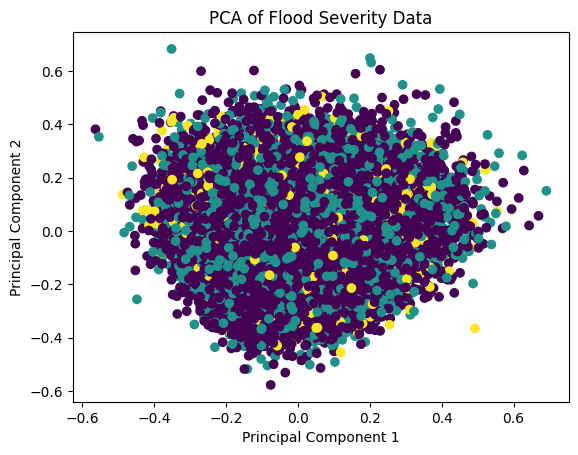

In [ ]:
# Dimensionality reduction and visualization with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_kbest)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Flood Severity Data')
plt.show()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_kbest, y, test_size=0.2, random_state=42)

In [ ]:
# Sample view of the dataset
df.head()

,0/,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability,SeverityLevel
781974,781974,4,3,5,6,3,2,10,3,3,...,6,4,5,2,3,5,5,8,0.505,0
937737,937737,7,3,5,1,3,7,3,2,3,...,4,4,6,7,2,6,6,4,0.470,0
907828,907828,4,3,3,5,4,5,4,4,3,...,8,5,6,5,8,7,7,4,0.490,0
784628,784628,5,7,6,5,3,6,6,4,9,...,4,5,8,12,7,5,4,4,0.610,2
662460,662460,10,2,4,3,5,3,3,7,7,...,3,6,6,6,6,7,6,6,0.540,1


## **Individual ML Models**

## **SVM**

In [ ]:
# SVM Model Implementation and Evaluation

svm = make_pipeline(StandardScaler(), LinearSVC(random_state=42, max_iter=10000))

svm.fit(X_train, y_train)

svm_pred = svm.predict(X_test)

print(f"SVM Accuracy: {accuracy_score(y_test, svm_pred)}")


SVM Accuracy: 0.8805073431241656


## **ANN**

In [ ]:
## Artificial Neural Network (ANN)
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

ann = Sequential()
ann.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
ann.add(Dropout(0.3))
ann.add(Dense(32, activation='relu'))
ann.add(Dropout(0.3))
ann.add(Dense(3, activation='softmax'))

ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

ann.fit(X_train, y_train_categorical, epochs=30, batch_size=32, verbose=1)

ann_loss, ann_accuracy = ann.evaluate(X_test, y_test_categorical, verbose=0)

print(f"ANN Accuracy: {ann_accuracy}")


Epoch 1/30
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7015 - loss: 0.7671
Epoch 2/30
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7918 - loss: 0.4852
Epoch 3/30
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8483 - loss: 0.3598
Epoch 4/30
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8711 - loss: 0.3238
Epoch 5/30
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8757 - loss: 0.3148
Epoch 6/30
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8832 - loss: 0.2975
Epoch 7/30
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8834 - loss: 0.2967
Epoch 8/30
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8827 - loss: 0.2914
Epoch 9/30
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8887 - loss: 0.2813
Epoch 10/30
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8877 - loss: 0.2783
Epoch 11/30
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8845 - loss: 0.2845
Epoch 12/30
1311/1311 ━━━━━━━

## **Random Forest**

In [ ]:
# Random Forest Classifier Implementation and Evaluation

rf = RandomForestClassifier(n_estimators=200, random_state=42)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_pred)}")

Random Forest Accuracy: 0.7566278847987793


### **KNN**

In [ ]:
# K-Nearest Neighbors (KNN) Classifier Implementation and Evaluation

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

print(f"KNN Accuracy: {accuracy_score(y_test, knn_pred)}")

KNN Accuracy: 0.7818996757581538


## **LSTM**

In [ ]:
# LSTM Model Implementation and Evaluation

X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


def create_lstm():

    model = Sequential()

    model.add(LSTM(64, input_shape=(X_train.shape[1], 1)))

    model.add(Dropout(0.2))

    model.add(Dense(32, activation='relu'))

    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


lstm_model = create_lstm()

lstm_model.fit(X_train_reshaped, y_train, epochs=5, batch_size=32, verbose=0)

lstm_pred = np.argmax(lstm_model.predict(X_test_reshaped), axis=1)

print(f"LSTM Accuracy: {accuracy_score(y_test, lstm_pred)}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


328/328 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
LSTM Accuracy: 0.8862292580583635


# **Ensemble Models**

## **Random Forest +** **KNN**

In [ ]:
# Ensemble 1: Random Forest + KNN

ensemble_rfk_knn = VotingClassifier(estimators=[('rf', rf), ('knn', knn)], voting='soft')

ensemble_rfk_knn.fit(X_train, y_train)

ensemble_rfk_knn_pred = ensemble_rfk_knn.predict(X_test)

print(f"Ensemble (RF + KNN) Accuracy: {accuracy_score(y_test, ensemble_rfk_knn_pred)}")


Ensemble (RF + KNN) Accuracy: 0.7876215906923517


### **Random Forest + LSTM**

In [ ]:
# Ensemble 2: Random Forest + LSTM

lstm_train_pred = lstm_model.predict(X_train_reshaped)
lstm_test_pred = lstm_model.predict(X_test_reshaped)

X_train_rf_lstm = np.concatenate([X_train, lstm_train_pred], axis=1)
X_test_rf_lstm = np.concatenate([X_test, lstm_test_pred], axis=1)

rf_with_lstm = RandomForestClassifier(n_estimators=300, random_state=60)
rf_with_lstm.fit(X_train_rf_lstm, y_train)

rf_with_lstm_pred = rf_with_lstm.predict(X_test_rf_lstm)

print(f"Ensemble (RF + LSTM) Accuracy: {accuracy_score(y_test, rf_with_lstm_pred)}")


1311/1311 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Ensemble (RF + LSTM) Accuracy: 0.9053023078390234


## **ANN + LSTM**

In [ ]:
#Ensemble 3: ANN + LSTM Ensemble Model

ann_train_pred = ann.predict(X_train)
ann_test_pred = ann.predict(X_test)

lstm_train_pred = lstm_model.predict(X_train_reshaped)
lstm_test_pred = lstm_model.predict(X_test_reshaped)

X_train_ensemble = np.concatenate([ann_train_pred, lstm_train_pred], axis=1)
X_test_ensemble = np.concatenate([ann_test_pred, lstm_test_pred], axis=1)

meta_model = SVC(kernel='linear', probability=True, random_state=60)
meta_model.fit(X_train_ensemble, y_train)

ensemble_pred = meta_model.predict(X_test_ensemble)

print(f"Ensemble Model Accuracy: {accuracy_score(y_test, ensemble_pred):.4f}")


1311/1311 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Ensemble Model Accuracy: 0.9032


## **LSTM + SVM**

In [ ]:
# Ensemble 4: LSTM + SVM

lstm_train_pred = lstm_model.predict(X_train_reshaped)
lstm_test_pred = lstm_model.predict(X_test_reshaped)

svm = SVC(kernel='linear', probability=True, random_state=60)

svm.fit(X_train, y_train)

svm_train_pred = svm.predict_proba(X_train)
svm_test_pred = svm.predict_proba(X_test)

X_train_ensemble = np.concatenate([lstm_train_pred, svm_train_pred], axis=1)
X_test_ensemble = np.concatenate([lstm_test_pred, svm_test_pred], axis=1)

meta_model = SVC(kernel='linear', probability=True, random_state=77)

meta_model.fit(X_train_ensemble, y_train)

# ensemble_pred = meta_model.predict(X_test_ensemble)
ensemble_pred_proba = meta_model.predict_proba(X_test_ensemble)
ensemble_pred = (ensemble_pred_proba[:, 1] > 0.6).astype(int)

print(f"Ensemble Model Accuracy: {accuracy_score(y_test, ensemble_pred):.4f}")


1311/1311 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Ensemble Model Accuracy: 0.8762


## **ANN + SVM**

In [ ]:
# Ensemble 5: ANN + SVM

ann = Sequential()
ann.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
ann.add(Dropout(0.3))
ann.add(Dense(32, activation='relu'))
ann.add(Dropout(0.3))
ann.add(Dense(3, activation='softmax'))

# Compile the ANN model
ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# One-hot encode the target labels for ANN
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# Train the ANN model
ann.fit(X_train, y_train_categorical, epochs=20, batch_size=32, verbose=1)

#nDefine the SVM model
svm = make_pipeline(StandardScaler(), SVC(random_state=42, probability=True))

# Train the SVM model
svm.fit(X_train, y_train)

# Create a Voting Classifier using soft voting (probabilities)

class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        y_categorical = to_categorical(y, num_classes=3)
        self.model.fit(X, y_categorical, epochs=20, batch_size=32, verbose=1)
        return self

    def predict(self, X):
        return self.model.predict(X).argmax(axis=1)  # Convert from one-hot to class labels

    def predict_proba(self, X):
        return self.model.predict(X)

# Wrap the ANN model in KerasClassifierWrapper
ann_model = KerasClassifierWrapper(ann)

# Define the ensemble model using VotingClassifier
ensemble = VotingClassifier(estimators=[('svm', svm), ('ann', ann_model)], voting='soft')

# Train the ensemble model
ensemble.fit(X_train, y_train)

ensemble_pred = ensemble.predict(X_test)
print(f"Ensemble Accuracy: {accuracy_score(y_test, ensemble_pred)}")


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1311/1311 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6901 - loss: 0.7721
Epoch 2/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7732 - loss: 0.5274
Epoch 3/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8395 - loss: 0.3753
Epoch 4/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8628 - loss: 0.3317
Epoch 5/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8746 - loss: 0.3073
Epoch 6/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8817 - loss: 0.2952
Epoch 7/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8787 - loss: 0.2993
Epoch 8/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8816 - loss: 0.2935
Epoch 9/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8846 - loss: 0.2850
Epoch 10/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8807 - loss: 0.2931
Epoch 11/20
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8873 - loss: 0.2755
Epoch 12/20
1311/1311 ━━━━━━━━━━━━━━━━━━━

# **ROC Curve**

ROC AUC Score for RF + LSTM Ensemble: 0.9720183115904346


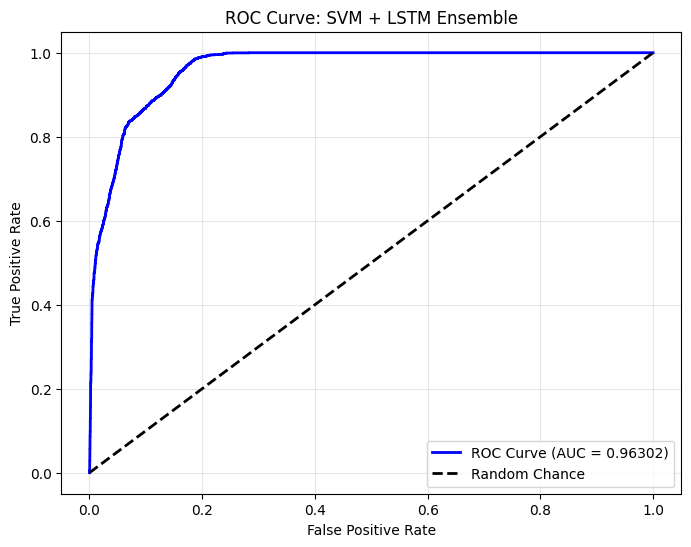

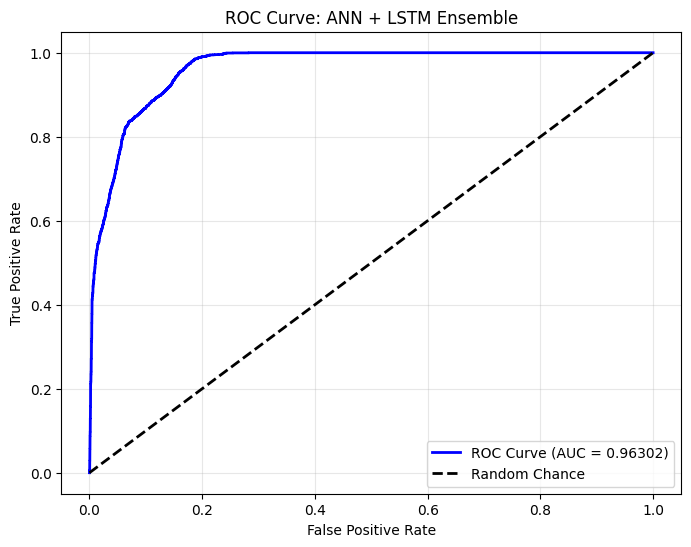

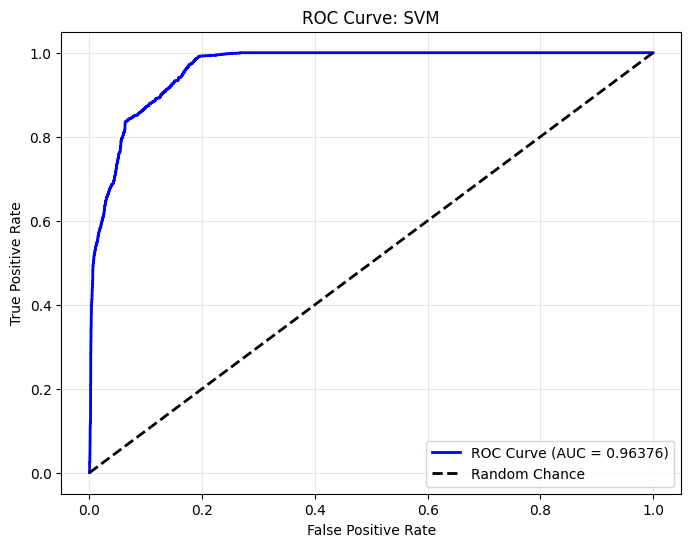

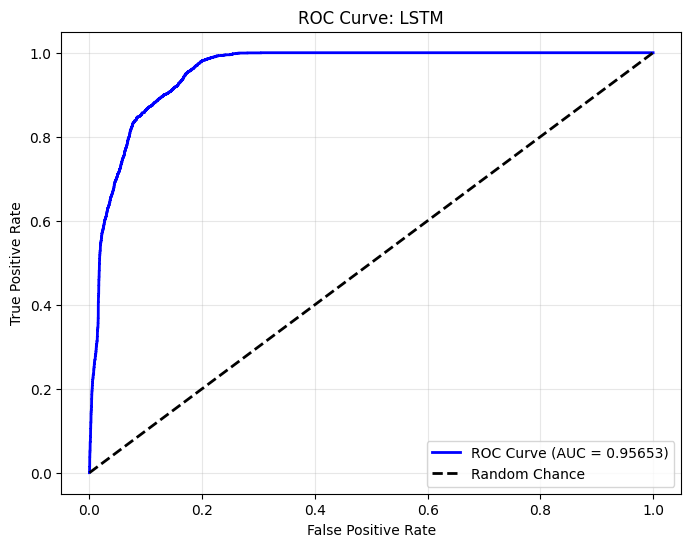

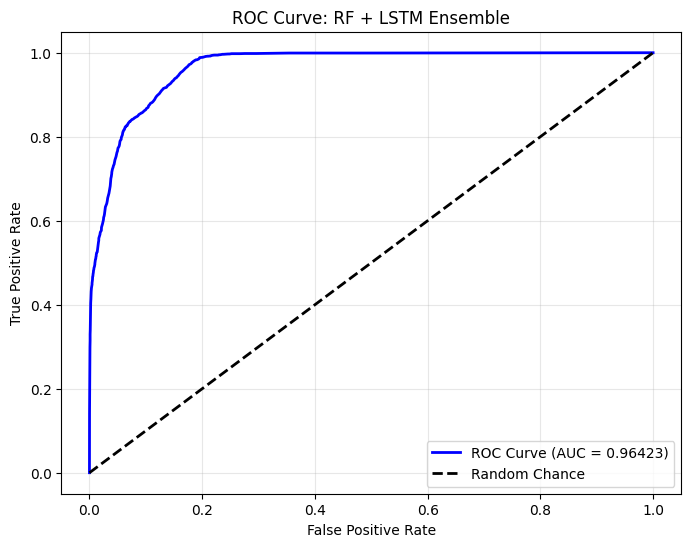

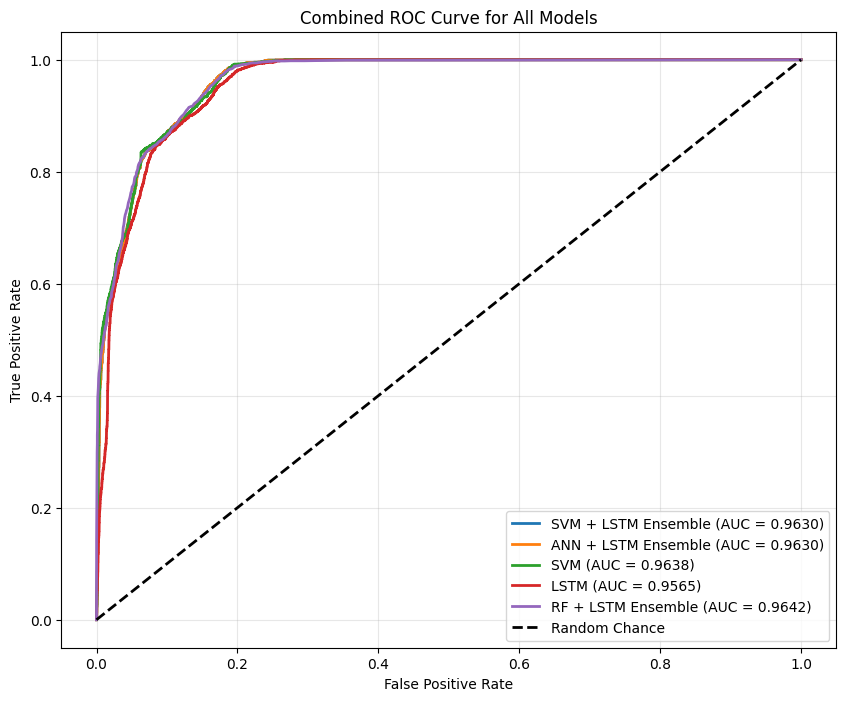

In [ ]:
# Import necessary libraries
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Step 1: Calculate ROC AUC Score for the RF + LSTM Ensemble Model
# Receiver Operating Characteristic (ROC) Curve
y_pred_proba = rf_with_lstm.predict_proba(X_test_rf_lstm)  # Predicted probabilities from RF + LSTM
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # AUC score for multi-class classification
print(f"ROC AUC Score for RF + LSTM Ensemble: {roc_auc}")

# Step 2: Binarize the target labels if the classification is multi-class
n_classes = len(np.unique(y_test))
if n_classes > 2:
    y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))  # Binarize the labels
else:
    y_test_binarized = y_test  # If binary classification, use the original labels

# Step 3: Calculate ROC and AUC for each model's prediction

# SVM + LSTM Ensemble Model
ensemble_svm_lstm_proba = meta_model.predict_proba(X_test_ensemble)  # Predicted probabilities from SVM + LSTM
fpr_ensemble_svm_lstm, tpr_ensemble_svm_lstm, _ = roc_curve(y_test, ensemble_svm_lstm_proba[:, 1], pos_label=1)  # Calculate FPR and TPR
auc_ensemble_svm_lstm = auc(fpr_ensemble_svm_lstm, tpr_ensemble_svm_lstm)  # Calculate AUC for SVM + LSTM

# ANN + LSTM Ensemble Model
ensemble_ann_lstm_proba = meta_model.predict_proba(X_test_ensemble)  # Predicted probabilities from ANN + LSTM
fpr_ensemble_ann_lstm, tpr_ensemble_ann_lstm, _ = roc_curve(y_test, ensemble_ann_lstm_proba[:, 1], pos_label=1)
auc_ensemble_ann_lstm = auc(fpr_ensemble_ann_lstm, tpr_ensemble_ann_lstm)  # Calculate AUC for ANN + LSTM

# SVM Model
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_test_pred[:, 1], pos_label=1)  # FPR and TPR for SVM
auc_svm = auc(fpr_svm, tpr_svm)  # AUC for SVM

# LSTM Model
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_test_pred[:, 1], pos_label=1)  # FPR and TPR for LSTM
auc_lstm = auc(fpr_lstm, tpr_lstm)  # AUC for LSTM

#  RF + LSTM Ensemble Model
ensemble_rf_lstm_proba = rf_with_lstm.predict_proba(X_test_rf_lstm)  # Predicted probabilities from RF + LSTM
fpr_ensemble_rf_lstm, tpr_ensemble_rf_lstm, _ = roc_curve(y_test, ensemble_rf_lstm_proba[:, 1], pos_label=1)  # FPR and TPR
auc_ensemble_rf_lstm = auc(fpr_ensemble_rf_lstm, tpr_ensemble_rf_lstm)  # AUC for RF + LSTM

# Step 5: Plot individual ROC curves for each model

def plot_roc_curve(fpr, tpr, auc_score, model_name):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', lw=2, label=f"ROC Curve (AUC = {auc_score:.5f})")
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Random Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve: {model_name}")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

plot_roc_curve(fpr_ensemble_svm_lstm, tpr_ensemble_svm_lstm, auc_ensemble_svm_lstm, "SVM + LSTM Ensemble")

plot_roc_curve(fpr_ensemble_ann_lstm, tpr_ensemble_ann_lstm, auc_ensemble_ann_lstm, "ANN + LSTM Ensemble")

plot_roc_curve(fpr_svm, tpr_svm, auc_svm, "SVM")

plot_roc_curve(fpr_lstm, tpr_lstm, auc_lstm, "LSTM")

plot_roc_curve(fpr_ensemble_rf_lstm, tpr_ensemble_rf_lstm, auc_ensemble_rf_lstm, "RF + LSTM Ensemble")

# Combined ROC curve plot
plt.figure(figsize=(10, 8))

plt.plot(fpr_ensemble_svm_lstm, tpr_ensemble_svm_lstm, label=f"SVM + LSTM Ensemble (AUC = {auc_ensemble_svm_lstm:.4f})", lw=2)
plt.plot(fpr_ensemble_ann_lstm, tpr_ensemble_ann_lstm, label=f"ANN + LSTM Ensemble (AUC = {auc_ensemble_ann_lstm:.4f})", lw=2)
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_svm:.4f})", lw=2)
plt.plot(fpr_lstm, tpr_lstm, label=f"LSTM (AUC = {auc_lstm:.4f})", lw=2)
plt.plot(fpr_ensemble_rf_lstm, tpr_ensemble_rf_lstm, label=f"RF + LSTM Ensemble (AUC = {auc_ensemble_rf_lstm:.4f})", lw=2)

plt.plot([0, 1], [0, 1], 'k--', label="Random Chance", lw=2)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Combined ROC Curve for All Models")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
